In [8]:
import os
os.sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import utilities as u
import preprocessing as pp
import behavior as b
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [18]:
# function for getting lick and speed data

def load_lick_mat(sess):
    with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
    VRDat,trial_info,tstart_inds,teleport_inds=data["VRDat"], data["trial_info"], data["tstart_inds"],data["teleport_inds"]
    
    lick_trial_mat= u.make_pos_bin_trial_matrices(VRDat['lick']._values,
                                                            VRDat['pos']._values,
                                                            tstart_inds,
                                                            teleport_inds,
                                                            mat_only=True,bin_size=10)
    return lick_trial_mat, trial_info


def build_matrix(mouse_list,first_sess=5,df=df):
    
    fs = u._first_sess_gen(mouse_list,first_sess)
    L= {}
    for m, (mouse,_fs) in enumerate(zip(mouse_list,fs)):    
        print(mouse)
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for i, sess_ind in enumerate(range(_fs,df_mouse.shape[0])):
            lick_mat, trial_info = load_lick_mat(df_mouse.iloc[sess_ind])
#             _mu= u.avg_by_morph(trial_info["morphs"],lick_mat)
            
            if i==0:
                lick_mu = lick_mat
                morph = trial_info['morphs']#+trial_info['towerJitter']+trial_info['bckgndJitter']+trial_info['wallJitter']
                rzone_pos = trial_info['rzone_entry']
            else:
                lick_mu = np.concatenate((lick_mu,lick_mat),axis=0)
                morph = np.concatenate((morph,trial_info['morphs']))
                rzone_pos = np.concatenate((rzone_pos,trial_info['rzone_entry']))
            
                
        L[mouse]={}
        L[mouse]['licks']=lick_mu
        L[mouse]['morphs']=morph
        L[mouse]['rzone_pos']=rzone_pos
        
       
        
    return L



In [19]:
LD_rare = build_matrix(['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706'],first_sess=[5,5,5,3,5,2])
LD_fam = build_matrix(['4222153.1','4222153.2','4222153.3','4222174.1','4222154.1','4343702.1'],first_sess=4)
LD_all = build_matrix(['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2','4222153.3','4222174.1','4222154.1','4343702.1'],first_sess=[5,5,5,3,5,2,4,4,4,4,4,4,4])

4139265.3
4139265.4
4139265.5
4222168.1
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1
4139265.3
4139265.4
4139265.5
4222168.1
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1


(600, 45)
(720, 45)
(600, 45)
(400, 45)
(100, 45)
(190, 45)
(281, 45)
(425, 45)
(90, 45)
(400, 45)
(510, 45)
(280, 45)


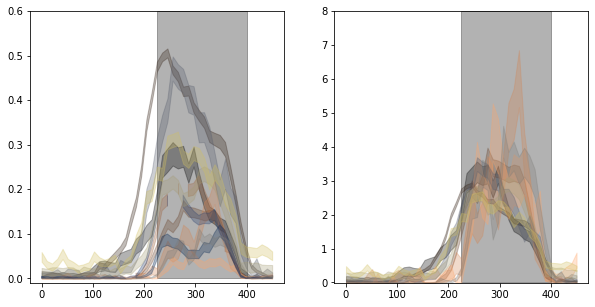

In [23]:
f,ax = plt.subplots(1,2,figsize=[10,5])
nbins = 45
cmaps = ['copper','cividis']



for i,L in enumerate([LD_rare,LD_fam]):
    nmice = len(L.keys())
    cm  = plt.cm.get_cmap(cmaps[i])
    
    for z, mouse in enumerate(L.keys()):
        licks = L[mouse]['licks']
        #licks/=licks.ravel().mean()
        morphs = L[mouse]['morphs']
        print(licks.shape)
        mu = licks.mean(axis=0)
        sem = sp.stats.sem(licks,axis=0)
        
        
        ax[0].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
        
        
        licks_n = np.copy(licks)
        licks_n/=licks_n.ravel().mean()
        mu = licks_n.mean(axis=0)
        sem = sp.stats.sem(licks_n,axis=0)
        
        ax[1].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
ax[0].fill_betweenx([0,.6],225,400,color='black',alpha=.3,zorder=0)
ax[1].fill_betweenx([0,8],225,400,color='black',alpha=.3,zorder=0)
ax[0].set_ylim([-.01,.6])
ax[1].set_ylim([-.01,8])
f.savefig("D:\\Morph_Results\\figures\\licks_by_mouse.pdf",format="pdf")

In [24]:
# function for lick accuracy (percent of licks in 50 cm preceding reward bin)
def pos_binned_licks(lick_mat,rpos,rz_edges=[220,260,290,320,380,481]):
    rpos[np.isnan(rpos)]=480
    rz_bins = np.digitize(rpos,rz_edges)-1
    
    mu_mat = np.zeros([len(rz_edges)-1,lick_mat.shape[1]])
    for b in range(len(rz_edges)-1):
        mu_mat[b,:] = lick_mat[rz_bins==b,:].mean(axis=0)
    return mu_mat



In [25]:
rz_edges=[220,260,290,320,380,481]
nmice = len(LD_all.keys())
# f,ax = plt.subplots()

MU_MAT=[]
for z, mouse in enumerate(LD_all.keys()):
    licks = LD_all[mouse]['licks']
    licks_n = np.copy(licks)
    licks_n/=licks.ravel().mean()
    
    rpos = LD_all[mouse]['rzone_pos']
#     print(licks.shape,licks_n.shape,rpos.shape)
    _mu_mat = pos_binned_licks(licks_n,rpos,rz_edges=rz_edges)
    MU_MAT.append(_mu_mat)
MU_MAT = np.squeeze(np.array(MU_MAT))
print(MU_MAT.shape)

(12, 5, 45)


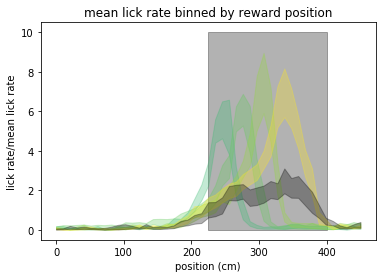

In [35]:
f,ax = plt.subplots()
ax.fill_betweenx([0,10],225,400,color='black',alpha=.3,zorder=0)

lr,sem = np.nanmean(MU_MAT,axis=0),sp.stats.sem(MU_MAT,axis=0,nan_policy='omit')
# print(lr.shape)
# print(lr,sem)
for b in range(len(rz_edges)-1):
    if b==4:
        ax.fill_between(np.linspace(0,450,num=nbins),lr[b,:]-sem[b,:],lr[b,:]+sem[b,:],color='black',alpha=.3)
    else:
        ax.fill_between(np.linspace(0,450,num=nbins),lr[b,:]-sem[b,:],lr[b,:]+sem[b,:],color=plt.cm.viridis(rz_edges[b+1]/rz_edges[4]),alpha=.3)
        
ax.set_ylabel('lick rate/mean lick rate')
ax.set_xlabel('position (cm)')
ax.set_title('mean lick rate binned by reward position')
f.savefig("D:\\Morph_Results\\figures\\allmice_licking_posbin.pdf",format="pdf")
# f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\allmice_licking_posbin.pdf",format='pdf')